In [1]:
from dotenv import load_dotenv
import os

load_dotenv()
if os.getenv("OPENAI_API_KEY"):
    print("Cargado correctamente API")

Cargado correctamente API


In [ ]:
from langchain_openai import ChatOpenAI

MODEL = "gpt-4o-mini"
MODEL2="gemini-2.5-flash"
llm = ChatOpenAI(model=MODEL,temperature=0.4)

In [3]:
#tools
# tool fecha actual
from datetime import datetime, date
from langchain_core.tools import tool

@tool
def current_date_time():
    """
    Tool: cuando el usuario hable de tiempo usa esta herramienta para determinar la fecha actual,
    realiza las operaciones necesarias para cumplir con la fecha que pide el usuario
    """
    today = date.today().isoformat()
    current_time = datetime.now().strftime("%Y-%m-%dT%H:%M:%S-05:00")
    # "current_date":today, 
    return {
        "current_date":today,
        "current_time":current_time
    }

In [4]:
tools = [current_date_time]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class MyState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]
    intencion: str
    summary: str

In [6]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

def identificar_intencion(state: MyState) -> dict:
    system_promp = """Tu tarea es identificar y clasificar la intención del usuario a partir de la conversación proporcionada, usando la siguiente lista de posibles intenciones:

    agendar_cita: El usuario desea reservar o programar una nueva cita.
    consultar_cita: El usuario quiere obtener información sobre una cita ya existente, como la hora o el lugar.
    reagendar_cita: El usuario busca cambiar la fecha o la hora de una cita previamente programada.
    otra: cuando el usuario realiza una conversacion fuera del contexto

    Debes responder solamente con una intención de esta lista: [agendar_cita, consultar_cita, reagendar_cita, otra]
    No agregues mas palabras
    """
    resp = llm.invoke([SystemMessage(content=system_promp)] + state["messages"])
    print(resp)
    intencion = resp.content.strip().lower()
    return {"messages": state.get("messages","") + [f"intencion identificada: {intencion}"], "intencion": intencion, 
    "summary": state.get("summary","") + f"Intención detectada: {intencion}"
    }

In [7]:
def consultar_cita(state: MyState) -> dict:
    system_prompt = """Eres una base de datos que tienes agendado citas, cuado el usuario te pida una consulta de cita tu vas a responder con la fecha y la hora de forma simulada.    
    """

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    cita = resp.content
    return {"messages": state["messages"] + [f"{cita}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {cita}"
            }

In [8]:
def agendar_cita(state: MyState) -> dict:
    system_prompt = """Eres un asistsente útil que agendas citas, tu principal rol es simular que creas citas. Utiliza la herramienta (tool) current_date_time para determinar la fecha actual"""

    resp = llm_with_tools.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    agenda = resp.content
    return {"messages": state["messages"] + [resp],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f" Cita consultada para el dia de {agenda}"
    }

In [9]:
def otra(state: MyState) -> dict:
    system_prompt = """Eres un asistsente útil, sigue la conversacion del usuario de forma natural"""

    resp = llm.invoke([SystemMessage(content=system_prompt)] + state.get("messages",""))
    agenda = resp.content
    return {"messages": state["messages"] + [f"{agenda}"],
            "intecion": state["intencion"],
            "summary": state.get("summary","") + f"Cita consultada para el dia de {agenda}"
    }

In [10]:
#funcion determinar ruta
def determinar_ruta(state: MyState) -> str:
    intencion = state['intencion']
    if intencion == "consultar_cita":
        return "consultar_cita"
    elif intencion == "agendar_cita":
        return "agendar_cita"
    else: 
        intencion == "otra"
        return "otra"


#### Resumen de la conversacion

In [11]:
# Resumir si la conversacion tiene mas de 4 mensajes 
def summarize_messages(state: MyState) -> dict:
    mensajes = state.get("messages",[])
    print(len(mensajes))
    if len(mensajes) > 4:
        summary = llm.invoke([HumanMessage(content=f"Haz un resumen breve de la conversación:\n{mensajes}")])
        print(summary)
        return {"summary": state.get("summary","") + "\n" + summary.content, "messages":mensajes[-2:]}
    return {}

In [12]:
lista = [1,3,5,7,9,0]
print(lista[-2:])

[9, 0]


In [13]:
import sqlite3

db_path="state_db/exmple.db"
conn=sqlite3.connect(db_path,check_same_thread = False)

In [14]:
#checkpointer
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver(conn)

In [15]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

#Define Grafo
builder = StateGraph(MyState)

#Define nodos
builder.add_node('identificar_intencion',identificar_intencion)
builder.add_node('consultar_cita',consultar_cita)
builder.add_node('agendar_cita',agendar_cita)
builder.add_node('otra',otra)
builder.add_node('resumir',summarize_messages)
builder.add_node("tools", ToolNode(tools))

#Define la secuencia de los agentes para este caso 
builder.add_edge(START,'identificar_intencion')
builder.add_edge('identificar_intencion','resumir')
builder.add_conditional_edges("resumir",determinar_ruta, {
        "consultar_cita": "consultar_cita",
        "agendar_cita": "agendar_cita",
        "otra": 'otra'
    })
#condicional para ejecutar herramientas (tools)
builder.add_conditional_edges(
    "agendar_cita",
    tools_condition,
    {
        "tools": "tools",
        END: END 
    }
)
builder.add_edge("tools", "agendar_cita")
builder.add_edge('consultar_cita',END)
builder.add_edge('agendar_cita',END)
builder.add_edge('otra',END)

#compilar
graph = builder.compile(checkpointer=memory)

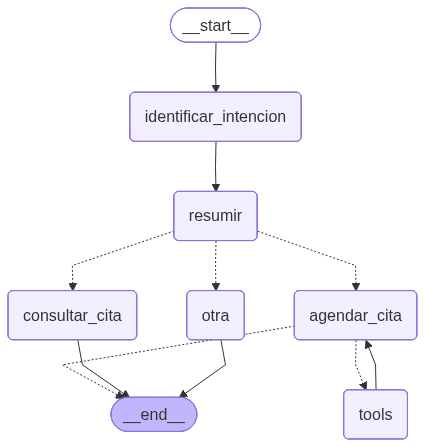

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [17]:
config = {"configurable": {"thread_id":"9"}}

In [24]:
content = "Para cuando tengo la cita con el doctor pallo"
messages = [HumanMessage(content=content)]
messages = graph.invoke({"messages": messages}, config)

for m in messages['messages']:
    m.pretty_print()

content='intencion identificada: consultar_cita' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 873, 'total_tokens': 881, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CTRRvOWUBpgdYXC6XShfGFVTzjFOn', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None} id='run--b34bc79a-09a8-4f76-b463-d6b3304dd2d0-0' usage_metadata={'input_tokens': 873, 'output_tokens': 8, 'total_tokens': 881, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
35
content='La conversación gira en torno a la solicitud de un usuario para agendar citas. El usuario repite varias veces su intención de "agendar una cita", y el asistente vi

In [25]:
messages


{'messages': [HumanMessage(content='agendame una cita', additional_kwargs={}, response_metadata={}, id='f475c012-ff72-4e3e-82de-07ef8facd590'),
  HumanMessage(content='intencion identificada: agendar_cita', additional_kwargs={}, response_metadata={}, id='ea2c55db-c839-4b7b-9605-67b1fc1e1b8c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_U2o9Jhorcze6QurKWWiXZ6bb', 'function': {'arguments': '{}', 'name': 'current_date_time'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 120, 'total_tokens': 131, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CT682Y5SY8VG7Q902pHyfCocdbwwI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs':